# Portfolio Optimization with Risk-Free Asset and Multiple Risky Assets

## Introduction
This notebook presents a framework for portfolio optimization that incorporates both a risk-free asset and multiple risky assets. The theory builds upon Modern Portfolio Theory (MPT), the Capital Market Line (CML), and the Capital Asset Pricing Model (CAPM).

---

## Assumptions
1. Markets are efficient.
2. Investors are rational and maximize utility.
3. A risk-free asset is available for borrowing and lending at a constant rate ($r_f$).
4. No transaction costs or taxes.
5. Asset returns are normally distributed (often relaxed).
6. Single-period investment horizon.

---

## Mathematical Formulation

### Risky Portfolio
The expected return $E[R_m]$ and risk $\sigma_m^2$ for a portfolio containing $n$ risky assets are:
$$
E[R_m] = \sum_{i=1}^{n} w_i E[R_i]
$$
$$
\sigma_m^2 = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j \rho_{ij} \sigma_i \sigma_j
$$

### Portfolio with Risk-Free Asset
The expected return $E[R_p]$ and risk $\sigma_p$ for the overall portfolio are:
$$
E[R_p] = w_f \cdot r_f + (1 - w_f) \cdot E[R_m]
$$
$$
\sigma_p = (1 - w_f) \cdot \sigma_m
$$

---

## Optimization Steps
1. **Risky Portfolio Optimization**: Identify the Tangency Portfolio that maximizes the Sharpe ratio:
$$
\text{Sharpe Ratio} = \frac{E[R_m] - r_f}{\sigma_m}
$$

2. **Capital Market Line (CML)**:
$$
E[R_p] = r_f + \left( \frac{E[R_m] - r_f}{\sigma_m} \right) \sigma_p
$$

3. **Asset Allocation**: Depending on the investor's risk tolerance, allocate between the risk-free asset and the Tangency Portfolio.
$$
w_f = 1 - \frac{\text{Investor's Risk Tolerance} \times (\text{Tangency Portfolio Excess Return})}{\text{Tangency Portfolio Risk}^2}
$$

---

## References
- Markowitz, H. (1952). "Portfolio Selection," The Journal of Finance, 7(1), 77-91.
- Sharpe, W.F. (1964). "Capital Asset Prices: A Theory of Market Equilibrium under Conditions of Risk," Journal of Finance, 19(3), 425-442.
- Luenberger, D.G. (1998). "Investment Science," Oxford University Press.

---

## Bias Consideration
The model assumes past statistics are indicative of future performance, which may not always be the case.


# Python Code

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  1 of 1 completed
Risk-free weight: 0.4
Optimal weights: [0.36237636 0.01762077 0.22000287]


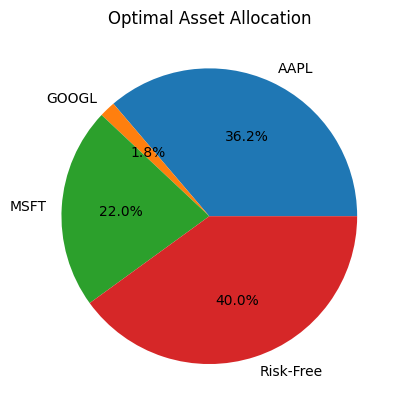

Portfolio expected return: 15.48%
Portfolio volatility: 14.74%
Portfolio Beta: 0.67
Portfolio Value-at-Risk (95% confidence): 8.77%
Portfolio Skewness: -0.11
Portfolio Kurtosis: 6.18
Sortino Ratio: 0.08
Treynor Ratio: 0.22
Expected Shortfall (CVaR): 2.15%


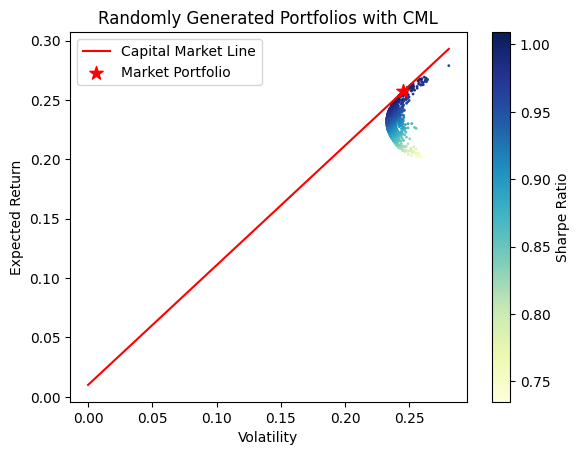

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import skew, kurtosis
import yfinance as yf

def fetch_adj_close_prices(tickers, start_date):
    return yf.download(tickers, start=start_date)['Adj Close']

# Fetch S&P 500 data
def fetch_sp500_data(start_date):
    return yf.download('^GSPC', start=start_date)['Adj Close']

def compute_daily_returns(price_data):
    return price_data.pct_change().dropna()

def annualize_covariance_matrix(daily_returns):
    return daily_returns.cov() * 252

def determine_risk_profile(score):
    thresholds = [(8, 11, 0.3), (12, 15, 0.4), (16, 19, 0.6), (20, 23, 0.8), (24, 26, 0.9)]
    for lower, upper, risk in thresholds:
        if lower <= score <= upper:
            return risk
    return None

def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

def optimize_portfolio(risk_profile, returns, cov_matrix, risk_free_rate):
    asset_count = len(returns)
    initial_weights = [1. / asset_count] * asset_count
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(asset_count))

    optimized_result = minimize(
        negative_sharpe_ratio, initial_weights,
        args=(returns, cov_matrix, risk_free_rate),
        method='SLSQP', bounds=bounds, constraints=constraints
    )

    optimal_weights = optimized_result.x
    final_portfolio_weights = optimal_weights * risk_profile
    risk_free_weight = 1 - risk_profile

    return risk_free_weight, final_portfolio_weights

def display_asset_allocation(asset_names, risk_free_weight, portfolio_weights):
    plt.pie([*portfolio_weights, risk_free_weight], labels=[*asset_names, 'Risk-Free'], autopct='%1.1f%%')
    plt.title('Optimal Asset Allocation')
    plt.show()

def generate_random_portfolios(tickers, returns, cov_matrix, risk_free_rate, num_portfolios=1000):
    random_results = np.zeros((4, num_portfolios))

    for i in range(num_portfolios):
        random_weights = np.random.random(len(tickers))
        random_weights /= np.sum(random_weights)

        portfolio_return = np.dot(random_weights, returns)
        portfolio_volatility = np.sqrt(np.dot(random_weights.T, np.dot(cov_matrix, random_weights)))

        random_results[0, i] = portfolio_return
        random_results[1, i] = portfolio_volatility
        random_results[2, i] = (portfolio_return - risk_free_rate) / portfolio_volatility

    return random_results

def plot_portfolios_with_cml(random_results, risk_free_rate):
    max_sharpe_idx = random_results[2].argmax()
    max_sharpe_return = random_results[0, max_sharpe_idx]
    max_sharpe_risk = random_results[1, max_sharpe_idx]

    plt.scatter(random_results[1, :], random_results[0, :], c=random_results[2, :], cmap='YlGnBu', marker='o', s=1)  # Adjusted s=5 to make scatter points smaller
    plt.xlabel('Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')

    # Plot CML
    x_cml = np.linspace(0, max(random_results[1, :]), 100)
    slope = (max_sharpe_return - risk_free_rate) / max_sharpe_risk
    y_cml = risk_free_rate + slope * x_cml
    plt.plot(x_cml, y_cml, color='red', label='Capital Market Line')

    # Highlight the Market Portfolio
    plt.scatter(max_sharpe_risk, max_sharpe_return, c='red', marker='*', s=100, label='Market Portfolio')

    plt.legend(loc='upper left')
    plt.title('Randomly Generated Portfolios with CML')
    plt.show()

def calculate_portfolio_beta(optimal_weights, individual_betas):
    return np.dot(optimal_weights, individual_betas)

# Calculate individual asset betas
def calculate_individual_betas(asset_returns, market_returns):
    cov_matrix = np.cov(asset_returns, market_returns)
    return cov_matrix[0, 1] / cov_matrix[1, 1]

def calculate_value_at_risk(portfolio_return, portfolio_volatility, confidence_level=0.95):
    z_score = norm.ppf(confidence_level)
    return -portfolio_return + z_score * portfolio_volatility

def calculate_sortino_ratio(returns, risk_free_rate, target_return=0.0):
    excess_return = returns - risk_free_rate
    downside_return = returns[returns < target_return]
    downside_deviation = np.std(downside_return)
    return np.mean(excess_return) / downside_deviation

def calculate_treynor_ratio(returns, risk_free_rate, beta):
    return (np.mean(returns) - risk_free_rate) / beta

def calculate_expected_shortfall(returns, confidence_level=0.05):
    return -np.mean(sorted(returns)[:int(len(returns) * confidence_level)])

if __name__ == '__main__':
    risk_tolerance_score = 18
    asset_tickers = ['AAPL', 'GOOGL', 'MSFT']
    risk_free_interest_rate = 0.01

    # Fetch asset and S&P 500 data
    price_data = fetch_adj_close_prices(asset_tickers, '2010-01-01')
    sp500_data = fetch_sp500_data('2010-01-01')

    # Compute daily and annual returns
    asset_daily_returns = compute_daily_returns(price_data)
    asset_annual_returns = asset_daily_returns.mean() * 252
    sp500_daily_returns = compute_daily_returns(sp500_data)
    sp500_annual_returns = sp500_daily_returns.mean() * 252

    # Calculate covariance matrix
    cov_matrix_annual = annualize_covariance_matrix(asset_daily_returns)

    # Determine risk profile and optimize portfolio
    risk_profile = determine_risk_profile(risk_tolerance_score)
    risk_free_weight, optimal_weights = optimize_portfolio(risk_profile, asset_annual_returns, cov_matrix_annual, risk_free_interest_rate)

    # Display asset allocation
    print(f"Risk-free weight: {risk_free_weight}")
    print(f"Optimal weights: {optimal_weights}")
    display_asset_allocation(asset_tickers, risk_free_weight, optimal_weights)

    # Calculate portfolio metrics
    portfolio_expected_return = np.dot(optimal_weights, asset_annual_returns)
    portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix_annual, optimal_weights)))
    print(f"Portfolio expected return: {portfolio_expected_return*100:.2f}%")
    print(f"Portfolio volatility: {portfolio_volatility*100:.2f}%")

    # Calculate individual asset betas
    individual_betas = [calculate_individual_betas(asset_daily_returns[ticker], sp500_daily_returns) for ticker in asset_tickers]

    # Calculate Portfolio Beta
    portfolio_beta = calculate_portfolio_beta(optimal_weights, individual_betas)
    print(f"Portfolio Beta: {portfolio_beta:.2f}")

    # Calculate Value-at-Risk (VaR) at 95% confidence level
    portfolio_var_95 = calculate_value_at_risk(portfolio_expected_return, portfolio_volatility, confidence_level=0.95)
    print(f"Portfolio Value-at-Risk (95% confidence): {portfolio_var_95*100:.2f}%")

    # Additional metrics
    portfolio_skewness = skew(asset_daily_returns.dot(optimal_weights))
    portfolio_kurtosis = kurtosis(asset_daily_returns.dot(optimal_weights))
    sortino_ratio = calculate_sortino_ratio(asset_daily_returns.dot(optimal_weights), risk_free_interest_rate / 252)
    treynor_ratio = calculate_treynor_ratio(portfolio_expected_return, risk_free_interest_rate, portfolio_beta)
    expected_shortfall = calculate_expected_shortfall(asset_daily_returns.dot(optimal_weights))

    print(f"Portfolio Skewness: {portfolio_skewness:.2f}")
    print(f"Portfolio Kurtosis: {portfolio_kurtosis:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Treynor Ratio: {treynor_ratio:.2f}")
    print(f"Expected Shortfall (CVaR): {expected_shortfall*100:.2f}%")

    # Plot random portfolios with CML and Market Portfolio
    random_results = generate_random_portfolios(asset_tickers, asset_annual_returns, cov_matrix_annual, risk_free_interest_rate)
    plot_portfolios_with_cml(random_results, risk_free_interest_rate)

# Best and worst case portfolio

This notebook aims to provide deterministic methods for simulating the worst-case and best-case scenarios for the price of a portfolio over a given period $X$ years, based on given expected annual return $\mu$ and volatility $\sigma$.

## Assumptions

1. Expected annual return $\mu$ and volatility $\sigma$ are constant over time.
2. The return distribution is assumed to be normally distributed.
3. Continuously compounded returns are assumed.

---

## General Formula for Portfolio Price

The general formula for future portfolio price $P(t)$ based on an initial price $P_0$ is given by:

$$
P(t) = P_0 \exp\left( (\mu - \frac{\sigma^2}{2}) t + \sigma \sqrt{t} Z \right)
$$

Here, $Z$ is a random variable following a standard normal distribution (mean=0, variance=1).

---

## Best-case Scenario

In a deterministic best-case scenario, we would substitute the maximum expected return within your confidence interval for $\mu$ and the minimum expected volatility for $\sigma$. Also, we would assume $Z$ to be at a value that reflects a high percentile (e.g., 95th percentile, $Z=1.645$) for a one-tailed confidence level in a standard normal distribution.

---

## Worst-case Scenario

In the deterministic worst-case scenario, we would use the minimum expected return and maximum volatility. We would also assume $Z$ to be at a value that reflects a low percentile (e.g., 5th percentile, $Z=-1.645$) for a one-tailed confidence level.

---

## Formula Application

You can apply these values to the formula to get a range of future prices $P(t)$ that represent your worst-case and best-case scenarios for each year up to $X$.

---

## Caveats

1. Both scenarios are simplistic and don't capture potential 'Black Swan' events.
2. The assumptions of constant volatility and return, as well as normally distributed returns, are convenient but not strictly true in real financial markets.

---

## References

- Hull, J.C., 2018. Options, futures, and other derivatives. Pearson Education Inc.

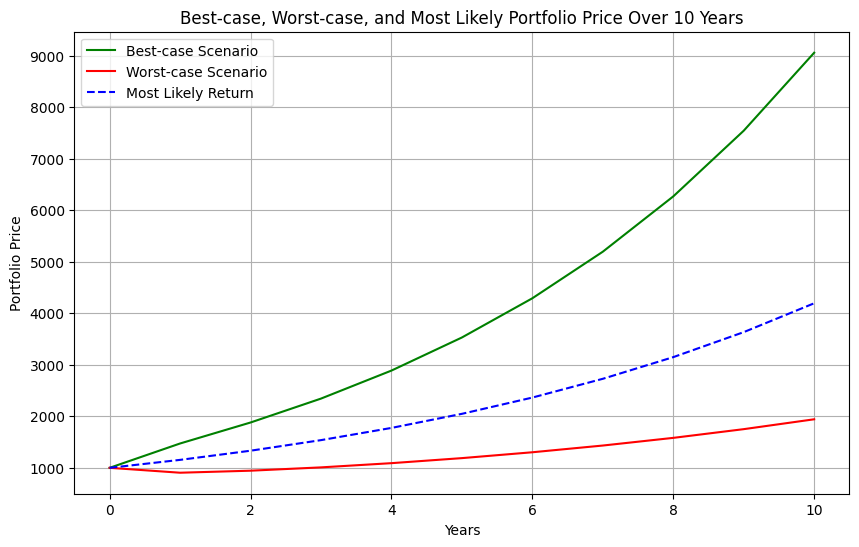

In [ ]:
def calculate_future_price(P0, mu, sigma, Z, t):
    return P0 * np.exp((mu - 0.5 * sigma ** 2) * t + sigma * np.sqrt(t) * Z)

def best_worst_most_likely_scenario(P0, mu, sigma, years):
    best_case_prices = [P0]
    worst_case_prices = [P0]
    most_likely_prices = [P0]

    for t in range(1, years + 1):
        best_case_price = calculate_future_price(P0, mu, sigma, 1.645, t)
        worst_case_price = calculate_future_price(P0, mu, sigma, -1.645, t)
        most_likely_price = calculate_future_price(P0, mu, sigma, 0, t)

        best_case_prices.append(best_case_price)
        worst_case_prices.append(worst_case_price)
        most_likely_prices.append(most_likely_price)

    return best_case_prices, worst_case_prices, most_likely_prices

def plot_scenarios(best_case_prices, worst_case_prices, most_likely_prices, years):
    plt.figure(figsize=(10, 6))

    plt.plot(range(0, years + 1), best_case_prices, label="Best-case Scenario", color='green')
    plt.plot(range(0, years + 1), worst_case_prices, label="Worst-case Scenario", color='red')
    plt.plot(range(0, years + 1), most_likely_prices, label="Most Likely Return", color='blue', linestyle='--')

    plt.xlabel('Years')
    plt.ylabel('Portfolio Price')
    plt.title(f'Best-case, Worst-case, and Most Likely Portfolio Price Over {years} Years')
    plt.legend()

    plt.grid(True)
    plt.show()

if __name__ == '__main__':

    P0 = 1000  # Initial portfolio price
    X = 10  # Number of years

    best_case_prices, worst_case_prices, most_likely_prices = best_worst_most_likely_scenario(P0, portfolio_expected_return, portfolio_volatility, X)
    plot_scenarios(best_case_prices, worst_case_prices, most_likely_prices, X)

# Investment Questionnaire for Portfolio Recommendation 2.0


### Personal Information

- Name: _________________
- Age: _________________

---

### Section 1: Risk Tolerance

1. How would you describe your knowledge of investments?
    - [ ]  Novice (1 point)
    - [ ]  Intermediate (2 points)
    - [ ]  Experienced (3 points)
2. What is your primary investment goal?
    - [ ]  Capital preservation (1 point)
    - [ ]  Balanced income and growth (2 points)
    - [ ]  Aggressive growth (3 points)
3. How do you react when the value of your investments drops?
    - [ ]  Sell some or all (1 point)
    - [ ]  Hold (2 points)
    - [ ]  Buy more (3 points)
4. I am comfortable with investments that may experience significant fluctuations in value.
    - [ ]  Strongly Disagree (1 point)
    - [ ]  Disagree (2 points)
    - [ ]  Neutral (3 points)
    - [ ]  Agree (4 points)
    - [ ]  Strongly Agree (5 points)

---

### Section 2: Investment Horizon

1. What is your planned investment horizon?
    - [ ]  less than 3 year (1 point)
    - [ ]  3-10 years (2 points)
    - [ ]  more than 10 years (3 points)
2. When do you expect to begin withdrawing money from your investments?
    - [ ]  less 5 year (1 point)
    - [ ]  5-15 years (2 points)
    - [ ]  more than 15 years (3 points)

---

### Section 3: Financial Objectives

1. What percentage of your income do you plan to invest?
    - [ ]  less than 10% (1 point)
    - [ ]  10-20% (2 points)
    - [ ]  more than 20% (3 points)
2. How important is liquidity to you?
    - [ ]  Very Important (1 point)
    - [ ]  Moderately Important (2 points)
    - [ ]  Not Important (3 points)

---

### Scoring System

Calculate the Total Score by summing all the points:

- 8-11 points: "The Paper Hands"
- 12-15 points: "The Stonks Analyst"
- 16-19 points: "The Diamond Hands"
- 20-23 points: "The YOLO Trader"
- 24-26 points: "To the Moon!"

---

### Assumptions

1. Respondents understand the questions and respond truthfully.
2. The scoring system is sufficient for an initial investor profile assessment, but periodic re-assessment is advised.

---

This updated questionnaire, tailored for individual investors, should offer a balanced approach to understanding an investor's risk profile and financial objectives.

### U**pdated Algorithm Example:**

Let *S* be the total score.

- If *S*∈[8,11], allocate 70% in bonds, **30%** in stocks.
- If *S*∈[12,15], allocate 60% in bonds, **40%** in stocks.
- If *S*∈[16,19], allocate 40% in bonds, **60%** in stocks.
- If *S*∈[20,23], allocate 20% in bonds, **80%** in stocks.
- If *S*∈[24,26], allocate 10% in bonds, **90%** in stocks.

# Model limits

### Data-Driven Bias
The model assumes that past statistics are indicative of future performance. This could introduce a look-ahead bias, especially when using machine learning or statistical methods for prediction (Lopez de Prado, 2018).

### Dependence of Max Sharpe Ratio Portfolio on Expected Returns
The Max Sharpe Ratio Portfolio, often termed the "Tangency Portfolio," is highly sensitive to the expected returns of the individual assets within the portfolio. This sensitivity poses a challenge because expected returns are often estimated based on historical data or predictive models, both of which are subject to estimation risk. Even minor inaccuracies in the estimation of expected returns can lead to a substantially different portfolio composition, thereby affecting the portfolio's risk-adjusted performance

# Perspectives

### Agnostic Portfolio Optimization
An agnostic approach to portfolio optimization focuses solely on minimizing variance and considering asset betas, sidestepping the uncertainties associated with estimating expected returns. This strategy aims for diversification and stability, particularly useful when the reliability of return predictions is in question. It aligns with the principles of the Capital Asset Pricing Model (CAPM), offering a potentially more stable investment alternative (Sharpe, 1964).

### Automation of Valuation Methods
The initiative to automate valuation methods focuses on the Discounted Cash Flow (DCF) and comparable companies analysis (comps). DCF involves estimating the future cash flows of an asset and discounting them to present value, offering an intrinsic valuation. Comparable companies analysis, on the other hand, evaluates an asset by comparing it to similar entities in the market. Automating these methods using Python aims to increase efficiency and reduce errors in the valuation process.